# Caso Técnico Xepelin
# SkForecast 
#### Florencia Margara
#### Fecha: 2022-08-26

## Import Libs

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import seaborn as sns

# Gráficos
# ==============================================================================
from matplotlib import pyplot as plt

# Model
# ==============================================================================
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load Data

In [2]:
df = pd.read_csv('data/data_final.csv', parse_dates=['period'] )

In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.rename(columns = {'totalAmount':'target'}, inplace = True)
df['lit'] = 'A'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   period         8 non-null      datetime64[ns]
 1   freq           8 non-null      int64         
 2   freqFinanced   8 non-null      int64         
 3   target         8 non-null      float64       
 4   meanAmount     8 non-null      float64       
 5   totalFinanced  8 non-null      float64       
 6   meanFinanced   8 non-null      float64       
 7   freqPayers     8 non-null      int64         
 8   freqReceiver   8 non-null      int64         
 9   lit            8 non-null      object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 768.0+ bytes


## Auto ML

In [5]:
# Preparación de datos 
# ==============================================================================
train_data = TimeSeriesDataFrame.from_data_frame(
    df[['lit','period','target']],
    id_column='lit',
    timestamp_column="period",
)

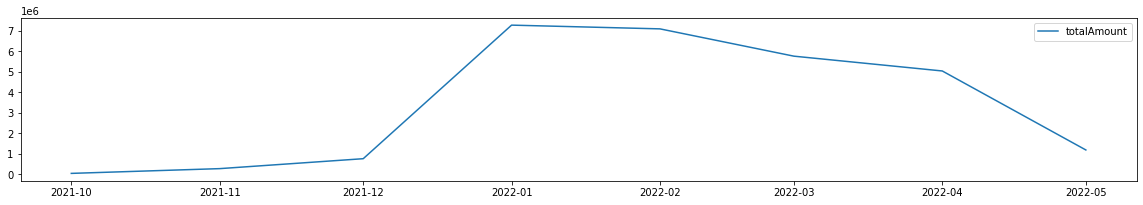

In [7]:
plt.figure(figsize=(20, 3))
for country in ["A"]:
    plt.plot(train_data.loc[country], label='totalAmount')
plt.legend()

In [8]:
prediction_length = 1

test_data = train_data.copy()  # the full data set

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

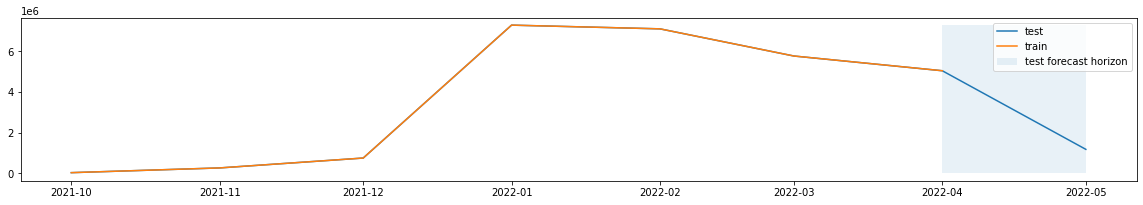

In [9]:
# Separación de datos en train y test
# ==============================================================================
plt.figure(figsize=(20, 3))
plt.plot(test_data.loc['A'], label="test")
plt.plot(train_data.loc['A'], label="train")

test_range = (
    test_data.loc['A'].index.max(),
    train_data.loc['A'].index.max(),
)

plt.fill_betweenx(
    y=(0, test_data.loc['A']["target"].max()),
    x1=test_range[0],
    x2=test_range[1],
    alpha=0.1,
    label="test forecast horizon",
)

plt.legend()

In [10]:
# Modeling
# ==============================================================================
predictor = TimeSeriesPredictor(
    path="autogluon-xepelinforecast",
    target="target",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 1,
 'target_column': 'target',
 'time_limit': None}
Provided training data set with 7 rows, 1 items. Average time series length is 7.0.
Training artifacts will be saved to: /shared_folder/modelos/scoreComportamental/v1.3/class/autogluon-xepelinforecast
Validation data is None, will hold the last prediction_length 1 time steps out to use as validation set.

Starting training. Start time is 2022-08-27 18:32:16
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transformer']
Training timeseries model AutoETS. 
	'pandas._libs.tslibs.offsets.MonthBegin' object has no attribute '_period_dtype_code'
Training timeseries model SimpleFeedForward. 
	-0.4158       = Validation score 

In [11]:
# Resultados
# ==============================================================================
predictor.leaderboard(test_data, silent=True)

# Omitió mucho modelos por falta de datos

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SimpleFeedForward,-2.535445,-0.415800,0.038139,0.018945,1.968986,1
1,WeightedEnsemble,-2.579100,-0.478489,0.036989,0.018945,0.004578,2


## Predicts

In [24]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


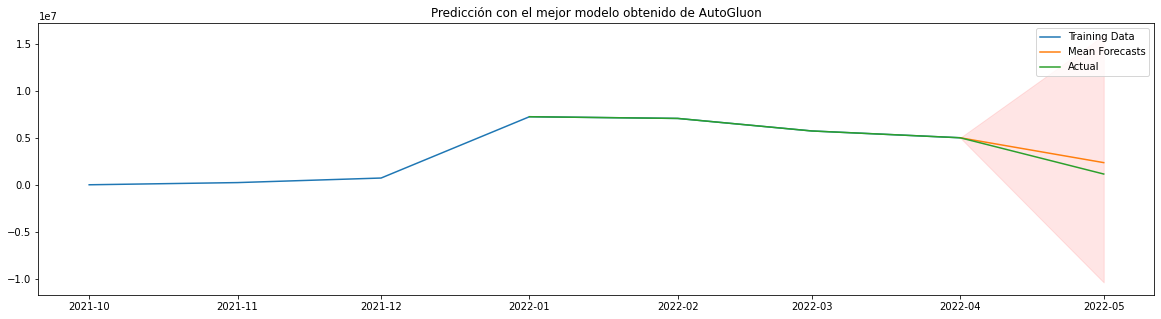

In [34]:
# Visualización de resultados
# ==============================================================================
plt.figure(figsize=(20, 5))

ytrue = train_data.loc['A']["target"]
ypred = predictions.loc['A']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['A']["target"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("Predicción con el mejor modelo obtenido de AutoGluon")
_ = plt.legend()

## Predicción para el mes de junio

In [35]:
pred_junio = predictor.predict(test_data)
pred_junio.rename(columns = {'mean':'target'}, inplace = True)

Model not specified in predict, will default to the model with the best validation score: SimpleFeedForward


In [36]:
pred_junio.iloc[:3,0].to_frame()

,,target
item_id,timestamp,
A,2022-06-01,4885693.5


In [37]:
pred = pd.concat([train_data, test_data, pred_junio.iloc[:3,0].to_frame()]).drop_duplicates()

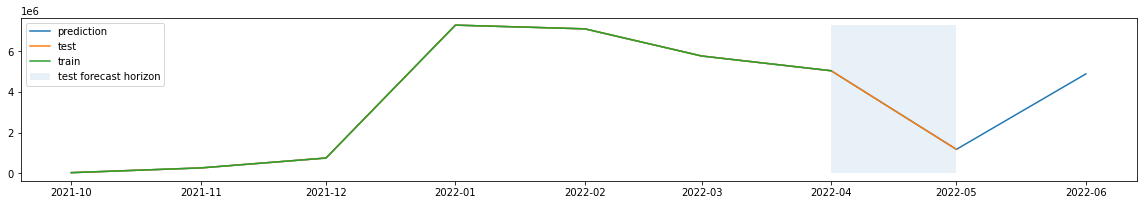

In [38]:
plt.figure(figsize=(20, 3))
plt.plot(pred.loc['A'], label="prediction")
plt.plot(test_data.loc['A'], label="test")
plt.plot(train_data.loc['A'], label="train")

test_range = (
    test_data.loc['A'].index.max(),
    train_data.loc['A'].index.max(),
    pred_junio.index.max()
)

plt.fill_betweenx(
    y=(0, test_data.loc['A']["target"].max()),
    x1=test_range[0],
    x2=test_range[1],
    alpha=0.1,
    label="test forecast horizon",
)

plt.legend()